<a href="https://colab.research.google.com/github/apriarami789/image_clasification/blob/main/KlasifikasiGambar_Mhd_ApriArami.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyek Klasifikasi Gambar: Satellite image Classification Dataset-RSI-CB256
- **Nama:** Mhd. Apri Arami
- **Email:** mhd.118290047@student.itera.ac.id
- **ID Dicoding:** apriarami718

## Informasi Dataset

https://www.kaggle.com/datasets/mahmoudreda55/satellite-image-classification/data

## Import Semua Packages/Library yang Digunakan

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import cv2
import random
import zipfile
from tqdm import tqdm
import shutil
import kagglehub

from sklearn.metrics import classification_report, confusion_matrix
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

## Data Preparation

### Data Loading

In [2]:
# Download latest version
path = kagglehub.dataset_download("mahmoudreda55/satellite-image-classification")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/satellite-image-classification


In [3]:
# melihat folder per label
path_new = "/kaggle/input/satellite-image-classification/data"
os.listdir(path_new)

['cloudy', 'desert', 'green_area', 'water']

### Data Preprocessing

#### Split Dataset

In [4]:
# Mencari distribusi resolusi gambar yang terdapat pada dataset
data_dir = path

image_files = [os.path.join(dp, f) for dp, dn, filenames in os.walk(data_dir) for f in filenames if f.endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

resolutions = {}
different_resolutions = False
first_resolution = None
different_resolution_images = []

for img_path in tqdm(image_files, desc="Checking image resolutions"):
    try:
        img = cv2.imread(img_path)
        if img is not None:
            height, width, _ = img.shape
            resolution = (width, height)

            if first_resolution is None:
                first_resolution = resolution

            if resolution != first_resolution:
                different_resolutions = True
                if len(different_resolution_images) < 2:
                    different_resolution_images.append(img_path)

            if resolution in resolutions:
                resolutions[resolution] += 1
            else:
                resolutions[resolution] = 1
        else:
            print(f"Warning: Could not read image file: {img_path}")
    except Exception as e:
        print(f"Error processing image file {img_path}: {e}")


print("\nStatus Resolusi Gambar:")
if different_resolutions:
    print("Resolusi semua gambar pada dataset ini BERBEDA.")
    print("\nContoh dua gambar dengan resolusi berbeda:")
    if len(different_resolution_images) >= 2:
        print(f"1. {different_resolution_images[0]} (Resolusi: {cv2.imread(different_resolution_images[0]).shape[1]}x{cv2.imread(different_resolution_images[0]).shape[0]})")
        print(f"2. {different_resolution_images[1]} (Resolusi: {cv2.imread(different_resolution_images[1]).shape[1]}x{cv2.imread(different_resolution_images[1]).shape[0]})")
    elif len(different_resolution_images) == 1:
         print(f"1. {different_resolution_images[0]} (Resolusi: {cv2.imread(different_resolution_images[0]).shape[1]}x{cv2.imread(different_resolution_images[0]).shape[0]})")
         print("Tidak dapat menemukan gambar kedua dengan resolusi berbeda dalam sampel yang diperiksa.")
    else:
        print("Tidak dapat menemukan gambar dengan resolusi berbeda dalam sampel yang diperiksa, meskipun status menunjukkan berbeda.")

else:
    print("Resolusi semua gambar pada dataset ini SAMA.")
    if first_resolution:
         print(f"Resolusi semua gambar adalah: {first_resolution[0]}x{first_resolution[1]}")
    else:
        print("Tidak dapat menentukan resolusi karena tidak ada gambar yang berhasil dibaca.")

print("\Distribusi Resolusi Gambar yang Ditemukan:")
for res, count in resolutions.items():
    print(f"  {res[0]}x{res[1]}: {count} gambar")

Checking image resolutions: 100%|██████████| 5631/5631 [00:31<00:00, 179.36it/s]



Status Resolusi Gambar:
Resolusi semua gambar pada dataset ini BERBEDA.

Contoh dua gambar dengan resolusi berbeda:
1. /kaggle/input/satellite-image-classification/data/green_area/Forest_2838.jpg (Resolusi: 64x64)
2. /kaggle/input/satellite-image-classification/data/green_area/Forest_205.jpg (Resolusi: 64x64)
\Distribusi Resolusi Gambar yang Ditemukan:
  256x256: 2631 gambar
  64x64: 3000 gambar


In [5]:
# Membagi data menjadi data training, validating dan teting

# Untuk membagi data menjadi training, validation, dan test dengan proporsi 70:20:10,
# ImageDataGenerator dengan `validation_split` hanya memungkinkan split menjadi training dan validation/test
# (tergantung bagaimana Anda menggunakannya).
# Untuk mendapatkan 70:20:10, kita perlu membagi data setidaknya dalam dua tahap
# atau secara manual membagi file gambar ke dalam folder terpisah.

# Metode 1: Membagi data secara manual ke dalam folder training, validation, dan test
# Ini adalah cara yang lebih bersih untuk memastikan proporsi split yang diinginkan.

# Tentukan direktori baru untuk data split
base_dir = '/content/dataset_split'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Bersihkan direktori jika sudah ada
if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

# Buat struktur direktori baru
os.makedirs(train_dir)
os.makedirs(validation_dir)
os.makedirs(test_dir)

# Mendapatkan daftar semua kelas (nama folder)
classes = [d for d in os.listdir(path_new) if os.path.isdir(os.path.join(path_new, d))]

# Bagi file gambar untuk setiap kelas
for cls in classes:
    class_path = os.path.join(path_new, cls)
    images = [os.path.join(class_path, f) for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
    random.shuffle(images) # Acak daftar gambar

    # Hitung jumlah gambar untuk setiap split
    total_images = len(images)
    train_count = int(0.7 * total_images)
    validation_count = int(0.2 * total_images)
    test_count = total_images - train_count - validation_count # Sisa untuk test

    # Bagi gambar ke dalam list
    train_images = images[:train_count]
    validation_images = images[train_count:train_count + validation_count]
    test_images = images[train_count + validation_count:]

    # Buat sub-direktori untuk kelas di setiap split
    os.makedirs(os.path.join(train_dir, cls))
    os.makedirs(os.path.join(validation_dir, cls))
    os.makedirs(os.path.join(test_dir, cls))

    # Pindahkan gambar ke direktori yang sesuai
    print(f"Processing class: {cls}")
    for img_path in tqdm(train_images, desc=f"Copying {cls} train"):
        shutil.copy(img_path, os.path.join(train_dir, cls, os.path.basename(img_path)))

    for img_path in tqdm(validation_images, desc=f"Copying {cls} validation"):
        shutil.copy(img_path, os.path.join(validation_dir, cls, os.path.basename(img_path)))

    for img_path in tqdm(test_images, desc=f"Copying {cls} test"):
        shutil.copy(img_path, os.path.join(test_dir, cls, os.path.basename(img_path)))

print("\nDataset split into training, validation, and test directories.")


Processing class: cloudy


Copying cloudy test: 100%|██████████| 150/150 [00:00<00:00, 1190.81it/s]


Processing class: desert


Copying desert test: 100%|██████████| 114/114 [00:00<00:00, 837.51it/s]


Processing class: green_area


Copying green_area test: 100%|██████████| 150/150 [00:00<00:00, 985.31it/s] 


Processing class: water


Copying water test: 100%|██████████| 150/150 [00:00<00:00, 1038.29it/s]


Dataset split into training, validation, and test directories.


In [6]:
# Augmentadi dan normalisasi gambaar

# Sekarang, gunakan ImageDataGenerator untuk memuat data dari direktori yang sudah dibagi.
# Normalisasi resolusi (target_size) dan augmentasi akan diterapkan di sini.

# ImageDataGenerator untuk data training (dengan augmentasi)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# ImageDataGenerator untuk data validation dan test (hanya normalisasi, tanpa augmentasi)
# Augmentasi biasanya hanya diterapkan pada data training.
validation_test_datagen = ImageDataGenerator(rescale=1./255)

# Memuat data training dari direktori training
train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=64,
    class_mode='categorical'
)

# Memuat data validasi dari direktori validation
validation_generator = validation_test_datagen.flow_from_directory(
    validation_dir,
    batch_size=64,
    class_mode='categorical'
)

# Memuat data test dari direktori test
test_generator = validation_test_datagen.flow_from_directory(
    test_dir,
    batch_size=64,
    class_mode='categorical',
    shuffle=False # Biasanya tidak mengacak data test untuk evaluasi yang konsisten
)


print("\nImage data generators created.")
print(f"Found {train_generator.samples} images belonging to {train_generator.num_classes} classes for training.")
print(f"Found {validation_generator.samples} images belonging to {validation_generator.num_classes} classes for validation.")
print(f"Found {test_generator.samples} images belonging to {test_generator.num_classes} classes for testing.")

# Anda sekarang memiliki tiga generator: train_generator, validation_generator, dan test_generator
# yang dapat digunakan untuk melatih, memvalidasi, dan mengevaluasi model Anda.


Found 3941 images belonging to 4 classes.
Found 1126 images belonging to 4 classes.
Found 564 images belonging to 4 classes.

Image data generators created.
Found 3941 images belonging to 4 classes for training.
Found 1126 images belonging to 4 classes for validation.
Found 564 images belonging to 4 classes for testing.



--- Menampilkan satu gambar per kelas dari Train Generator ---


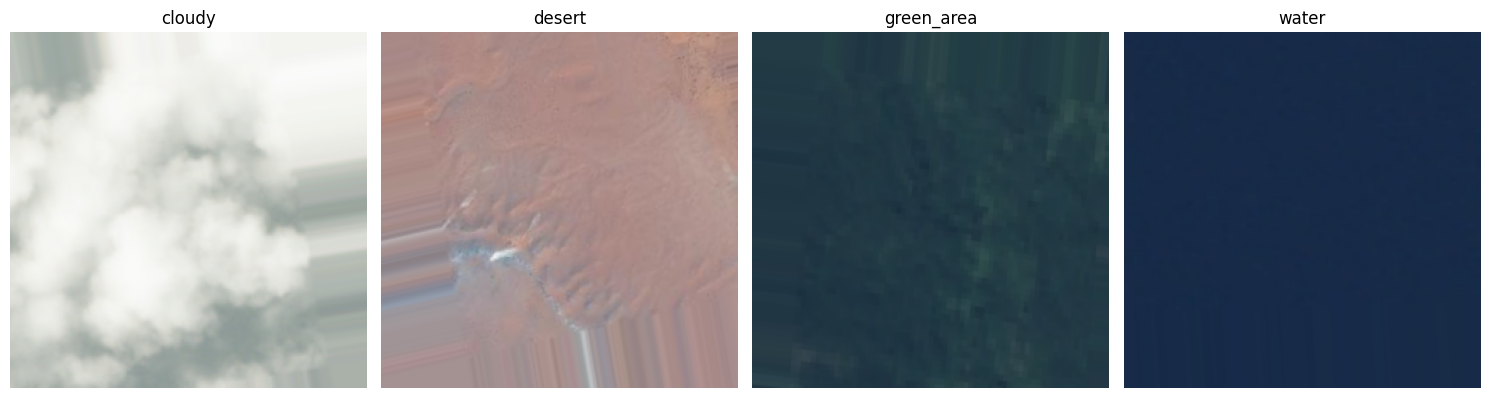


--- Menampilkan satu gambar per kelas dari Validation Generator ---


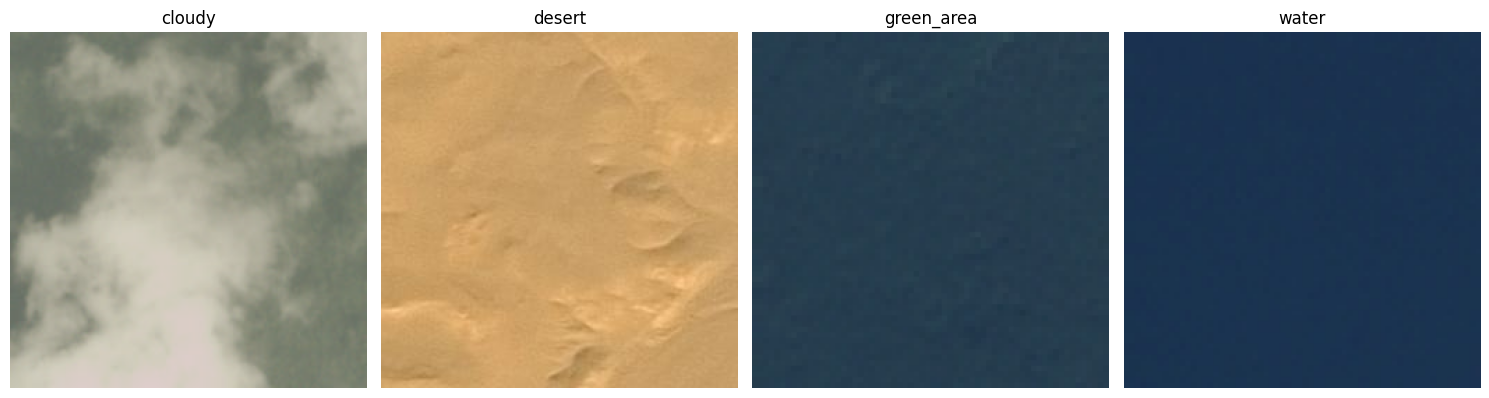


--- Menampilkan satu gambar per kelas dari Test Generator ---


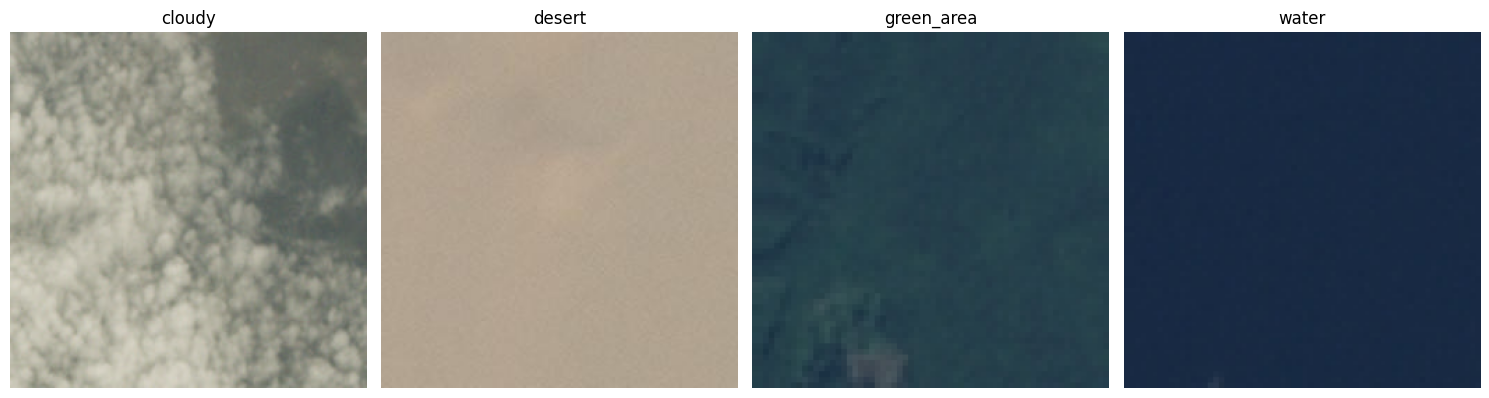

In [7]:
# Fungsi untuk menampilkan satu gambar per kelas
def display_one_image_per_class(generator, title):
    print(f"\n--- Menampilkan satu gambar per kelas dari {title} ---")

    class_indices = generator.class_indices
    labels = list(class_indices.keys())
    num_classes = len(labels)

    # Membuat dictionary untuk menyimpan indeks gambar pertama yang ditemukan per kelas
    images_per_class = {}

    # Reset generator untuk memastikan kita mulai dari awal
    generator.reset()

    # Loop melalui batch untuk menemukan gambar untuk setiap kelas
    # Batasi jumlah batch untuk menghindari looping terlalu lama
    max_batches_to_check = len(generator) # Cek semua batch yang tersedia

    for i in range(min(max_batches_to_check, 100)): # Batasi hingga 100 batch
        images, batch_labels = next(generator)
        # Ubah one-hot encoding ke indeks kelas
        batch_labels_indices = np.argmax(batch_labels, axis=1)

        for j in range(images.shape[0]): # Loop melalui setiap gambar dalam batch
            img = images[j]
            label_index = batch_labels_indices[j]
            class_name = labels[label_index]

            if class_name not in images_per_class:
                images_per_class[class_name] = img
                # Hentikan jika sudah menemukan satu gambar untuk setiap kelas
                if len(images_per_class) == num_classes:
                    break

        if len(images_per_class) == num_classes:
            break # Hentikan looping batch jika semua kelas sudah terwakili

    # Menampilkan gambar
    plt.figure(figsize=(15, 5))
    for i, label in enumerate(labels):
        if label in images_per_class:
            plt.subplot(1, num_classes, i + 1)
            plt.imshow(images_per_class[label])
            plt.title(label)
            plt.axis('off')
        else:
            print(f"Warning: Tidak dapat menemukan gambar untuk kelas '{label}' dalam batch yang diperiksa.")

    plt.tight_layout()
    plt.show()

# Tampilkan gambar dari train_generator
display_one_image_per_class(train_generator, "Train Generator")

# Tampilkan gambar dari validation_generator
display_one_image_per_class(validation_generator, "Validation Generator")

# Tampilkan gambar dari test_generator
display_one_image_per_class(test_generator, "Test Generator")

## Modelling

In [24]:
# 1) Hyperparameters
IMG_HEIGHT, IMG_WIDTH = 256, 256
BATCH_SIZE = train_generator.batch_size
NUM_CLASSES = train_generator.num_classes
LR = 1e-3
WEIGHT_DECAY = 1e-4      # untuk L2 regularization
DROPOUT_RATE = 0.3

In [25]:
# 2) Bangun arsitektur CNN dengan regularization
model = models.Sequential([
    layers.Conv2D(32, (3,3), padding='same', activation='relu',
                  kernel_regularizer=regularizers.l1_l2(l1=WEIGHT_DECAY,l2=WEIGHT_DECAY),
                  input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3,3), padding='same', activation='relu',
                  kernel_regularizer=regularizers.l1_l2(l1=WEIGHT_DECAY,l2=WEIGHT_DECAY)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),

    layers.Conv2D(128, (3,3), padding='same', activation='relu',
                  kernel_regularizer=regularizers.l1_l2(l1=WEIGHT_DECAY,l2=WEIGHT_DECAY)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),

    layers.Flatten(),
    layers.Dense(512, activation='relu',
                 bias_regularizer=regularizers.l1_l2(l1=WEIGHT_DECAY,l2=WEIGHT_DECAY)),
    layers.BatchNormalization(),
    layers.Dropout(DROPOUT_RATE),

    layers.Dense(128, activation='relu',
                 bias_regularizer=regularizers.l1_l2(l1=WEIGHT_DECAY,l2=WEIGHT_DECAY)),
    layers.BatchNormalization(),
    layers.Dropout(DROPOUT_RATE),

    layers.Dense(32, activation='relu',
                 bias_regularizer=regularizers.l1_l2(l1=WEIGHT_DECAY,l2=WEIGHT_DECAY)),
    layers.BatchNormalization(),
    layers.Dropout(DROPOUT_RATE),

    layers.Dense(NUM_CLASSES, activation='softmax', activity_regularizer=regularizers.l1_l2(l1=WEIGHT_DECAY,l2=WEIGHT_DECAY))
])

# 3) Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)              │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 512)            │    67,109,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 4)              │           13

 Total params: 67,276,132 (256.64 MB)

 Trainable params: 67,274,340 (256.63 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [26]:
# 4) Setup Callbacks
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=8, verbose=1, restore_best_weights=True),
    ModelCheckpoint('best_satellite_cnn.h5', monitor='val_accuracy', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1)
]

In [27]:
# 5) Train
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=callbacks
)

Epoch 1/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7776 - loss: 0.9580
Epoch 1: val_accuracy improved from -inf to 0.20870, saving model to best_satellite_cnn.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - accuracy: 0.7786 - loss: 0.9554 - val_accuracy: 0.2087 - val_loss: 2.1985 - learning_rate: 0.0010
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8626 - loss: 0.6948
Epoch 2: val_accuracy improved from 0.20870 to 0.26643, saving model to best_satellite_cnn.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.8626 - loss: 0.6943 - val_accuracy: 0.2664 - val_loss: 2.5576 - learning_rate: 0.0010
Epoch 3/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8915 - loss: 0.5974
Epoch 3: val_accuracy did not improve from 0.26643
62/62 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.8914 - loss: 0.5976 - val_accuracy: 0.2664 - val_loss: 2.9857 - learning_rate: 0.0010
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8828 - loss: 0.5822
Epoch 4: val_accuracy improved from 0.26643 to 0.39698, saving model to best_satellite_cnn.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.8828 - loss: 0.5822 - val_accuracy: 0.3970 - val_loss: 2.3681 - learning_rate: 0.0010
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8723 - loss: 0.5852
Epoch 5: val_accuracy improved from 0.39698 to 0.43606, saving model to best_satellite_cnn.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.8725 - loss: 0.5849 - val_accuracy: 0.4361 - val_loss: 1.8593 - learning_rate: 0.0010
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9050 - loss: 0.5155
Epoch 6: val_accuracy improved from 0.43606 to 0.52575, saving model to best_satellite_cnn.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.9048 - loss: 0.5159 - val_accuracy: 0.5258 - val_loss: 1.9792 - learning_rate: 0.0010
Epoch 7/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9011 - loss: 0.5108
Epoch 7: val_accuracy improved from 0.52575 to 0.57016, saving model to best_satellite_cnn.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.9011 - loss: 0.5108 - val_accuracy: 0.5702 - val_loss: 1.5955 - learning_rate: 0.0010
Epoch 8/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9088 - loss: 0.4967
Epoch 8: val_accuracy improved from 0.57016 to 0.63854, saving model to best_satellite_cnn.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.9088 - loss: 0.4966 - val_accuracy: 0.6385 - val_loss: 1.4789 - learning_rate: 0.0010
Epoch 9/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9014 - loss: 0.4781
Epoch 9: val_accuracy improved from 0.63854 to 0.66341, saving model to best_satellite_cnn.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.9014 - loss: 0.4779 - val_accuracy: 0.6634 - val_loss: 2.0159 - learning_rate: 0.0010
Epoch 10/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9084 - loss: 0.4453
Epoch 10: val_accuracy did not improve from 0.66341
62/62 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.9084 - loss: 0.4454 - val_accuracy: 0.6590 - val_loss: 1.4936 - learning_rate: 0.0010
Epoch 11/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9141 - loss: 0.4312
Epoch 11: val_accuracy did not improve from 0.66341
62/62 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.9141 - loss: 0.4312 - val_accuracy: 0.5986 - val_loss: 1.5870 - learning_rate: 0.0010
Epoch 12/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9042 - loss: 0.4177
Epoch 12: val_accuracy improved from 0.66341 to 0.90409, saving model to best_satellite_cnn.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.9043 - loss: 0.4178 - val_accuracy: 0.9041 - val_loss: 0.4050 - learning_rate: 0.0010
Epoch 13/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9006 - loss: 0.4372
Epoch 13: val_accuracy did not improve from 0.90409
62/62 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.9006 - loss: 0.4369 - val_accuracy: 0.7913 - val_loss: 0.7491 - learning_rate: 0.0010
Epoch 14/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9015 - loss: 0.4050
Epoch 14: val_accuracy did not improve from 0.90409
62/62 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.9016 - loss: 0.4049 - val_accuracy: 0.5808 - val_loss: 1.7963 - learning_rate: 0.0010
Epoch 15/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9044 - loss: 0.3924
Epoch 15: val_accuracy did not improve from 0.90409
62/62 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.9044 - loss: 0.3924 - val_accuracy: 0.6972 - val_loss: 0.8860 - learning_rate: 0.0010
Epoch 16/30
62/62 ━━━━━━━━━━━━━━━━━━

Hasil akurasi dan loss yang paling terbaik diberikan pada pelatihan epoch 12, dimana:
*   Akurasi training = 90,43 %
*   loss training = 41,78 %
*   Akurasi validating = 90,42 %
*   loss training = 41,77 %





## Evaluasi dan Visualisasi

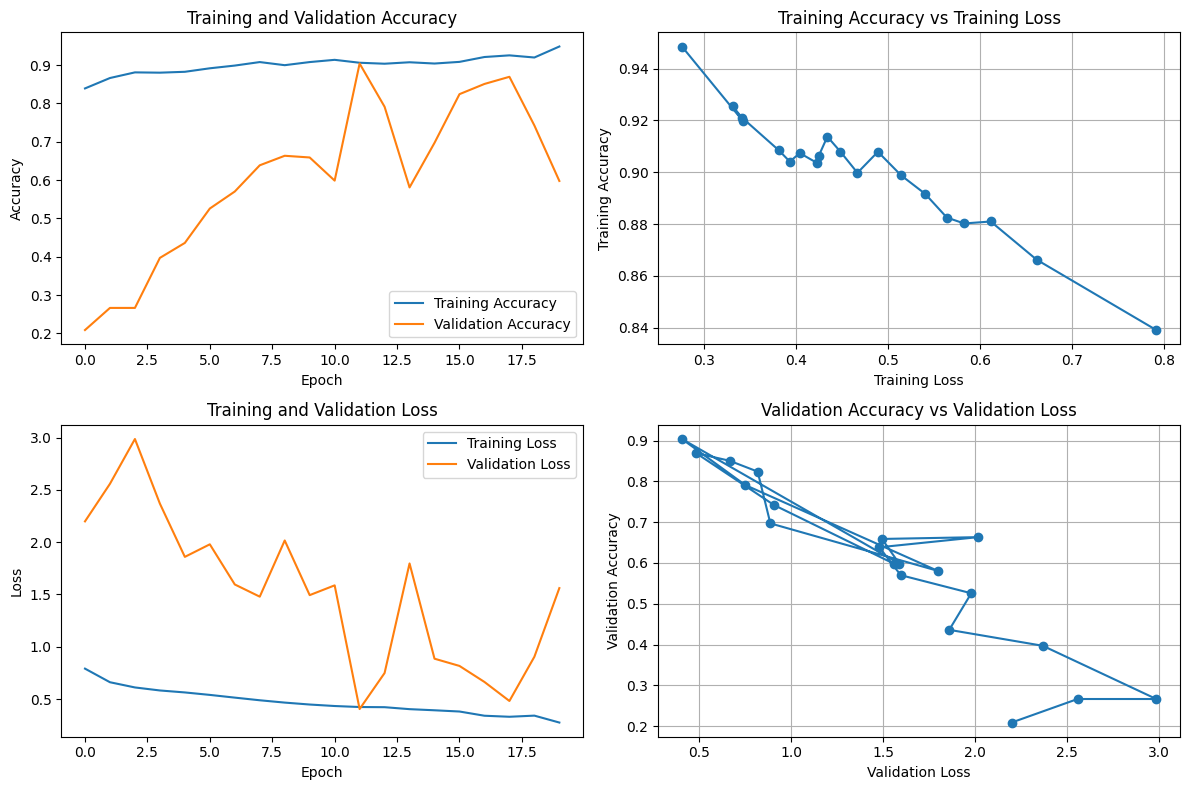

In [33]:
# Visualisasi Performa latih model

# Ambil nilai accuracy dan loss dari history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

# Plot Akurasi Training dan Validation
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot Loss Training dan Validation
plt.subplot(2, 2, 3)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Plot Akurasi terhadap Loss Model (Training)
plt.subplot(2, 2, 2)
plt.plot(loss, acc, 'o-')
plt.title('Training Accuracy vs Training Loss')
plt.xlabel('Training Loss')
plt.ylabel('Training Accuracy')
plt.grid(True)

# Plot Akurasi terhadap Loss Model (Validation)
plt.subplot(2, 2, 4)
plt.plot(val_loss, val_acc, 'o-')
plt.title('Validation Accuracy vs Validation Loss')
plt.xlabel('Validation Loss')
plt.ylabel('Validation Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()

Model loaded for evaluation.

Evaluating model on test data...
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 267ms/step - accuracy: 0.9362 - loss: 0.3679

Test Loss: 0.4249
Test Accuracy: 0.9078

Generating predictions for classification report and confusion matrix...
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step

--- Classification Report ---
              precision    recall  f1-score   support

      cloudy       0.93      0.97      0.95       150
      desert       0.99      0.93      0.96       114
  green_area       0.85      0.90      0.88       150
       water       0.88      0.84      0.86       150

    accuracy                           0.91       564
   macro avg       0.91      0.91      0.91       564
weighted avg       0.91      0.91      0.91       564


--- Confusion Matrix ---


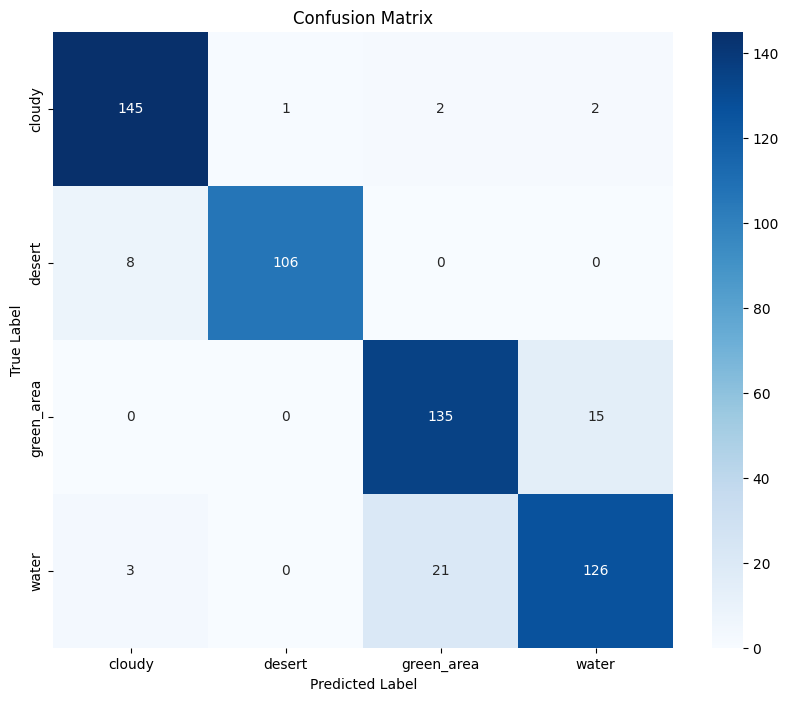

In [35]:
# prompt: buatkan evaluasi model 'best_satellite_cnn.h5' yang sudah dilatih diatas

# Muat model terbaik
best_model = models.load_model('best_satellite_cnn.h5')

print("Model loaded for evaluation.")

# Evaluasi model pada data test
print("\nEvaluating model on test data...")
loss, accuracy = best_model.evaluate(test_generator)

print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Prediksi pada data test untuk mendapatkan metrik lainnya
print("\nGenerating predictions for classification report and confusion matrix...")
# Menggunakan predict_generator untuk mendapatkan prediksi probabilitas
predictions = best_model.predict(test_generator)
# Mendapatkan indeks kelas dengan probabilitas tertinggi (prediksi kelas)
predicted_classes = np.argmax(predictions, axis=1)

# Mendapatkan label kelas sebenarnya dari test generator
# Ini penting karena shuffle=False saat membuat test_generator,
# sehingga urutan gambar dan labelnya sesuai dengan urutan file dalam direktori test.
true_classes = test_generator.classes

# Mendapatkan nama-nama kelas dalam urutan yang benar dari generator
class_labels = list(test_generator.class_indices.keys())
# Mengurutkan nama-nama kelas berdasarkan indeksnya
sorted_class_labels = [label for label, index in sorted(test_generator.class_indices.items(), key=lambda item: item[1])]


# Menghasilkan Classification Report
print("\n--- Classification Report ---")
print(classification_report(true_classes, predicted_classes, target_names=sorted_class_labels))

# Menghasilkan Confusion Matrix
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(true_classes, predicted_classes)

# Visualisasi Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted_class_labels, yticklabels=sorted_class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Hasil prediksi model:
*   Akurasi testing = 90,78 %
*   loss testing = 42,49 %



## Konversi Model

In [46]:
# Muat model terbaik
best_model = tf.keras.models.load_model('best_satellite_cnn.h5')

In [40]:
# @title Tensorflow.js
# 1. Konversi ke TensorFlow.js
print("\n--- Mengkonversi model ke TensorFlow.js ---")
!pip install tensorflowjs

# Buat direktori output
!mkdir tfjs_model

# Konversi
# Menggunakan --weights_manifest_path untuk menyimpan manifest di lokasi yang sama
# Jika model memiliki optimasi atau lapisan kustom, mungkin perlu konfigurasi tambahan
try:
    !tensorflowjs_converter \
        --input_format=keras \
        best_satellite_cnn.h5 \
        tfjs_model

    print("Konversi ke TFJS berhasil disimpan di direktori 'tfjs_model'")
except Exception as e:
    print(f"Error saat mengkonversi ke TFJS: {e}")
    print("Pastikan tensorflowjs_converter terinstal dan file input benar.")



--- Mengkonversi model ke TensorFlow.js ---
mkdir: cannot create directory ‘tfjs_model’: File exists
2025-06-20 09:59:09.368534: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750413549.389804   24417 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750413549.396007   24417 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file
Konversi ke TFJS berhasil disimpan di direktori 'tfjs_model'


In [41]:
# membuat zip file tfjs_model

# Cek isi folder tfjs_model
!ls tfjs_model

# Buat file zip
zip_filename = 'tfjs_model.zip'
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk('tfjs_model'):
        for file in files:
            zipf.write(os.path.join(root, file),
                       os.path.relpath(os.path.join(root, file), 'tfjs_model'))

print(f"\nFolder 'tfjs_model' berhasil dikompres menjadi '{zip_filename}'")

group1-shard10of65.bin	group1-shard30of65.bin	group1-shard50of65.bin
group1-shard11of65.bin	group1-shard31of65.bin	group1-shard51of65.bin
group1-shard12of65.bin	group1-shard32of65.bin	group1-shard52of65.bin
group1-shard13of65.bin	group1-shard33of65.bin	group1-shard53of65.bin
group1-shard14of65.bin	group1-shard34of65.bin	group1-shard54of65.bin
group1-shard15of65.bin	group1-shard35of65.bin	group1-shard55of65.bin
group1-shard16of65.bin	group1-shard36of65.bin	group1-shard56of65.bin
group1-shard17of65.bin	group1-shard37of65.bin	group1-shard57of65.bin
group1-shard18of65.bin	group1-shard38of65.bin	group1-shard58of65.bin
group1-shard19of65.bin	group1-shard39of65.bin	group1-shard59of65.bin
group1-shard1of65.bin	group1-shard3of65.bin	group1-shard5of65.bin
group1-shard20of65.bin	group1-shard40of65.bin	group1-shard60of65.bin
group1-shard21of65.bin	group1-shard41of65.bin	group1-shard61of65.bin
group1-shard22of65.bin	group1-shard42of65.bin	group1-shard62of65.bin
group1-shard23of65.bin	group1-shard43

In [38]:
# @title TFLite
# 2. Konversi ke TFLite
print("\n--- Mengkonversi model ke TFLite ---")

# Buat TFLite Converter
converter = tf.lite.TFLiteConverter.from_keras_model(best_model)

# Lakukan konversi
# Anda bisa menambahkan optimasi di sini jika diperlukan, contoh:
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.target_spec.supported_types = [tf.float16] # Untuk float16 quantization

tflite_model = converter.convert()

# Simpan model TFLite
tflite_model_path = 'satellite_cnn.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f"Konversi ke TFLite berhasil disimpan sebagai '{tflite_model_path}'")


--- Mengkonversi model ke TFLite ---
Saved artifact at '/tmp/tmpw2qkvofn'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_layer_4')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  139808488918864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139808488915216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139808488917328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139808488917904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139808488915984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139808488915792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139808488918480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139808488921168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139808488919056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139808488921744: TensorSpec(shape=(), dtype=t

In [47]:
# 3. Konversi ke SavedModel TensorFlow
print("\n--- Menyimpan model sebagai TensorFlow SavedModel ---")

# Buat direktori output
saved_model_dir = 'saved_model'
# Hapus direktori jika sudah ada untuk menghindari error
if os.path.exists(saved_model_dir):
    shutil.rmtree(saved_model_dir)

# Simpan model dalam format SavedModel
tf.saved_model.save(best_model, saved_model_dir)

print(f"Model TensorFlow SavedModel berhasil disimpan di direktori '{saved_model_dir}'")

# Opsional: Verifikasi SavedModel
print("\n--- Memverifikasi SavedModel ---")
try:
    reloaded_model = tf.saved_model.load(saved_model_dir)
    print("SavedModel berhasil dimuat kembali untuk verifikasi.")
    # Anda bisa menambahkan langkah verifikasi lebih lanjut, seperti menjalankan inferensi
    # test_image_batch, test_label_batch = next(test_generator)
    # reloaded_model.predict(test_image_batch) # Contoh inferensi
except Exception as e:
    print(f"Error saat memuat kembali SavedModel: {e}")


--- Menyimpan model sebagai TensorFlow SavedModel ---
Model TensorFlow SavedModel berhasil disimpan di direktori 'saved_model'

--- Memverifikasi SavedModel ---
SavedModel berhasil dimuat kembali untuk verifikasi.


In [48]:
# Kompres folder SavedModel menjadi zip
saved_model_zip_filename = 'saved_model.zip'
print(f"\n--- Mengkompres folder '{saved_model_dir}' menjadi '{saved_model_zip_filename}' ---")

try:
    with zipfile.ZipFile(saved_model_zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(saved_model_dir):
            for file in files:
                zipf.write(os.path.join(root, file),
                           os.path.relpath(os.path.join(root, file), saved_model_dir))

    print(f"Folder '{saved_model_dir}' berhasil dikompres menjadi '{saved_model_zip_filename}'")

    # Cek apakah file zip terbuat
    !ls -lh saved_model.zip

except Exception as e:
    print(f"Error saat mengkompres folder SavedModel: {e}")



--- Mengkompres folder 'saved_model' menjadi 'saved_model.zip' ---
Folder 'saved_model' berhasil dikompres menjadi 'saved_model.zip'
-rw-r--r-- 1 root root 239M Jun 20 10:13 saved_model.zip


## Inference (Optional)


--- Melakukan Inferensi pada satu gambar per kelas dari Test Generator ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


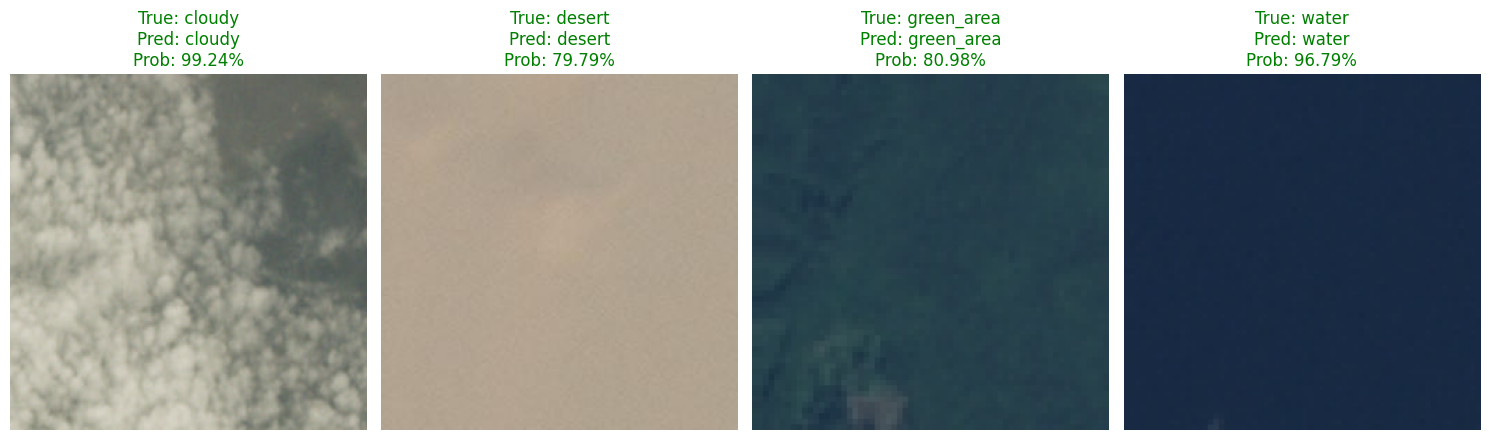


Inferensi selesai.


In [51]:
# Muat model terbaik (pastikan sudah dimuat sebelumnya)
# best_model = tf.keras.models.load_model('best_satellite_cnn.h5') # uncomment jika belum dimuat

# Reset test generator untuk memastikan urutan gambar konsisten
test_generator.reset()

# Dapatkan nama-nama kelas dari generator
class_labels = list(test_generator.class_indices.keys())
sorted_class_labels = [label for label, index in sorted(test_generator.class_indices.items(), key=lambda item: item[1])]

print("\n--- Melakukan Inferensi pada satu gambar per kelas dari Test Generator ---")

# Buat dictionary untuk menyimpan indeks gambar pertama yang ditemukan per kelas
images_to_predict = {}
images_paths_for_display = {} # Untuk menyimpan path jika perlu dibaca ulang

# Loop melalui test generator untuk menemukan satu gambar per kelas
# Batasi jumlah batch yang diperiksa
max_batches_to_check_inference = len(test_generator) # Cek semua batch yang tersedia

found_all_classes = False
for i in range(max_batches_to_check_inference):
    images, batch_labels = next(test_generator)
    batch_labels_indices = np.argmax(batch_labels, axis=1)

    for j in range(images.shape[0]):
        img = images[j]
        label_index = batch_labels_indices[j]
        class_name = sorted_class_labels[label_index] # Gunakan sorted_class_labels

        if class_name not in images_to_predict:
            # Simpan gambar dan indeks aslinya di batch
            images_to_predict[class_name] = img

            # Dapatkan path asli gambar dari generator (sedikit tricky)
            # Filepaths dalam generator sudah diurutkan berdasarkan kelas
            # Karena shuffle=False, indeks gambar di batch sesuai dengan indeks di generator.filenames
            original_filepath = test_generator.filepaths[i * test_generator.batch_size + j]
            images_paths_for_display[class_name] = original_filepath

            # Hentikan jika sudah menemukan satu gambar untuk setiap kelas
            if len(images_to_predict) == test_generator.num_classes:
                found_all_classes = True
                break

    if found_all_classes:
        break

# Jika tidak semua kelas ditemukan setelah memeriksa semua batch
if not found_all_classes:
     print("Warning: Tidak semua kelas ditemukan di test generator setelah memeriksa semua batch.")


# Lakukan prediksi dan tampilkan hasilnya
plt.figure(figsize=(15, 5))

# Mengurutkan kelas sesuai dengan urutan label pada generator (alfabetis)
for i, class_name in enumerate(sorted_class_labels):
    if class_name in images_to_predict:
        img_for_display = images_to_predict[class_name]

        # Persiapan untuk prediksi: tambahkan dimensi batch
        img_for_prediction = np.expand_dims(img_for_display, axis=0)

        # Lakukan prediksi
        predictions = best_model.predict(img_for_prediction)
        predicted_label_index = np.argmax(predictions)
        predicted_class_name = sorted_class_labels[predicted_label_index]
        confidence = predictions[0][predicted_label_index] * 100

        # Tampilkan gambar
        plt.subplot(1, len(sorted_class_labels), i + 1)
        # matplotlib.pyplot.imshow mengharapkan nilai dalam rentang [0, 1] atau [0, 255]
        # Karena kita sudah mereskalakan gambar saat membuat generator (rescale=1./255),
        # gambarnya sudah dalam rentang [0, 1].
        plt.imshow(img_for_display)

        # Tampilkan judul dengan prediksi dan probabilitas
        title = f"True: {class_name}\nPred: {predicted_class_name}\nProb: {confidence:.2f}%"
        color = 'green' if class_name == predicted_class_name else 'red'
        plt.title(title, color=color)
        plt.axis('off')
    else:
         print(f"Skip class '{class_name}' as no image was found in the sampled batches.")


plt.tight_layout()
plt.show()

print("\nInferensi selesai.")